In [1]:
!pip install transformers accelerate onnxruntime


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
print(torch.cuda.memory_allocated()/1024**2, "MB used")
print(torch.cuda.memory_reserved()/1024**2, "MB reserved")

0.0 MB used
0.0 MB reserved


In [4]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

from nltk.corpus import stopwords 
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from torch.nn.utils.rnn import pad_sequence
import string

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
df = pd.read_csv("C:/Users/roaam/Downloads/hyprid/Final_new_dataset/Final_dataset.csv")


df['status'].value_counts()

status
Normal                  16020
Depression              15086
Suicidal                10641
Anxiety                  3613
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

In [6]:
df.isnull().sum()

statement    0
status       0
dtype: int64

# Clean Text Function

In [7]:
print(df.isnull().sum())

statement    0
status       0
dtype: int64


In [8]:
from sklearn.utils import resample

In [9]:
import pandas as pd

# Step 1: Optional - sample a subset if dataset is large
df_sample = df.sample(n=min(20000, len(df)), random_state=42)

# Step 2: Determine the target size for resampling
class_counts = df_sample['status'].value_counts()
majority_size = class_counts.max()  # Automatically pick the largest class
print(f"Target size for all classes: {majority_size}")

# Step 3: Resampling function
def resample_class(df_subset, target_size):
    """
    Resample a dataframe subset to the target size.
    Oversample if smaller, undersample if larger.
    """
    if len(df_subset) == 0:
        return df_subset
    if len(df_subset) >= target_size:
        # Undersample
        return df_subset.sample(n=target_size, random_state=42, replace=False)
    else:
        # Oversample
        return resample(df_subset, replace=True, n_samples=target_size, random_state=42)

# Step 4: Apply resampling to all classes
resampled_dfs = []
for status_val in class_counts.index:
    df_class = df_sample[df_sample['status'] == status_val]
    resampled_df = resample_class(df_class, majority_size)
    print(f"Status {status_val}: Original {len(df_class)} → Resampled {len(resampled_df)}")
    resampled_dfs.append(resampled_df)

# Step 5: Combine resampled data
df_balanced = pd.concat(resampled_dfs, axis=0).reset_index(drop=True)

# Step 6: Keep only relevant columns
data = df_balanced[['statement', 'status']]


Target size for all classes: 6353
Status Normal: Original 6353 → Resampled 6353
Status Depression: Original 5912 → Resampled 6353
Status Suicidal: Original 4101 → Resampled 6353
Status Anxiety: Original 1389 → Resampled 6353
Status Bipolar: Original 1019 → Resampled 6353
Status Stress: Original 886 → Resampled 6353
Status Personality disorder: Original 340 → Resampled 6353


In [10]:
print(data['status'].value_counts())
print(f"\nTotal samples: {len(data)}")

status
Normal                  6353
Depression              6353
Suicidal                6353
Anxiety                 6353
Bipolar                 6353
Stress                  6353
Personality disorder    6353
Name: count, dtype: int64

Total samples: 44471


In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['status_encoded'] = label_encoder.fit_transform(data['status'])

In [12]:
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

Anxiety: 0
Bipolar: 1
Depression: 2
Normal: 3
Personality disorder: 4
Stress: 5
Suicidal: 6


# Load Dataset

In [13]:



train_df, valid_df = train_test_split(data, test_size=0.15, stratify=data["status_encoded"], random_state=42)



# Dataset / Tokenizer

In [14]:
MODEL_NAME = "microsoft/deberta-v3-base"
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 160


class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = df["statement"].tolist()
        self.labels = df["status_encoded"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "status_encoded": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_loader = DataLoader(TextDataset(train_df), batch_size=96, shuffle=True)
valid_loader = DataLoader(TextDataset(valid_df), batch_size=96, shuffle=False)


# Model: BiLSTM + Attention on DeBERTa

In [15]:

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads

        # projection for attention
        self.attn = nn.Linear(hidden_dim, hidden_dim)

        # attention scoring
        self.context_vector = nn.Linear(self.head_dim, 1)

        # restore dimension to original hidden_dim
        self.restore = nn.Linear(self.head_dim, hidden_dim)

    def forward(self, x):
        # x: (B, L, H)
        B, L, H = x.size()

        # 1) linear projection
        x_proj = self.attn(x)  # (B, L, H)

        # 2) split heads
        x_proj = x_proj.view(B, L, self.num_heads, self.head_dim)  # (B, L, heads, head_dim)

        # 3) mean over heads → (B, L, head_dim)
        x_heads = x_proj.mean(dim=2)

        # 4) attention weights (softmax over sequence length)
        weights = torch.softmax(self.context_vector(x_heads), dim=1)  # (B, L, 1)

        # 5) weighted sum over sequence length → (B, head_dim)
        context = torch.sum(weights * x_heads, dim=1)

        # 6) restore to original hidden_dim (B, H)
        context = self.restore(context)

        return context  # shape: (B, hidden_dim)



In [16]:
class DeBERTa_BiLSTM_Attn_FT(nn.Module):
    def __init__(self, model_name="microsoft/deberta-v3-base",
                 lstm_hidden=512, lstm_layers=2,
                 num_classes=7, dropout=0.4):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden = self.transformer.config.hidden_size  # usually 1024

        # Fine-tune last 6 layers only
        for name, param in self.transformer.named_parameters():
            param.requires_grad = False
            for i in range(6):
                if f"encoder.layer.{self.transformer.config.num_hidden_layers - 1 - i}" in name:
                    param.requires_grad = True

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=hidden,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )

        # Multi-head attention
        self.attn = MultiHeadAttentionLayer(lstm_hidden * 2, num_heads=4)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)  # input matches attn output

    def forward(self, input_ids, attention_mask, debug=False):
        # transformer outputs
        outputs = self.transformer(input_ids, attention_mask)
        seq = outputs.last_hidden_state  # (B, L, H)
        if debug:
            print("Transformer output:", seq.shape)

        # BiLSTM
        lstm_out, _ = self.lstm(seq)  # (B, L, lstm_hidden*2)
        if debug:
            print("LSTM output:", lstm_out.shape)

        # attention
        attn_out = self.attn(lstm_out)  # (B, lstm_hidden*2)
        if debug:
            print("Attention output:", attn_out.shape)

        # dropout + fc
        x = self.dropout(attn_out)
        logits = self.fc(x)  # (B, num_classes)
        if debug:
            print("Logits shape:", logits.shape)
        return logits
    


# Training Setup

In [17]:
model = DeBERTa_BiLSTM_Attn_FT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler()


EPOCHS =60
# Scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)


# Training Loop (AMP Enabled)

In [18]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [19]:
def train_one_epoch(debug=False):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    

    for step,batch in enumerate(tqdm(train_loader,desc="trainning")):
        inp = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["status_encoded"].to(device)
        
        debug_flag = debug and (EPOCHS == 0 and step == 0)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            logits = model(inp, attn, debug=debug_flag)
            loss = criterion(logits, labels)
            
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * labels.size(0)  # weighted by batch size
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        

    scheduler.step()
    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc





# Validation with Accuracy

In [20]:
def validate(debug=False):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    

    with torch.no_grad():
        for step,batch in enumerate(tqdm(valid_loader, desc="Validation")):
            inp = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            labels = batch["status_encoded"].to(device)
            
            debug_flag = debug and (EPOCHS == 0 and step == 0)
            
            logits = model(inp, attn, debug_flag=debug_flag)
            loss = criterion(logits, labels)

            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            first_batch = False

    return val_loss / total, correct / total

In [ ]:

EPOCHS = 65

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

    train_loss, train_acc = train_one_epoch(epoch,debug=True)
    val_loss, val_acc = validate(epoch,debug=True)


    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")




# Confusion Matrix + Classification Report

In [ ]:
label2id = {
    "Normal":0,
    "Depression":1,
    "Suicidal":2,
    "Anxiety":3,
    "Bi-Polar":4,
    "Stress":5,
    "Personality Disorder":6
}

target_names = list(label2id.keys())
target_names

['Normal',
 'Depression',
 'Suicidal',
 'Anxiety',
 'Bi-Polar',
 'Stress',
 'Personality Disorder']


Classification Report:
                      precision    recall  f1-score   support

              Normal       0.99      0.93      0.96       946
          Depression       0.91      0.92      0.92       946
            Suicidal       0.92      0.92      0.92       946
             Anxiety       0.99      0.99      0.99       946
            Bi-Polar       0.99      1.00      1.00       946
              Stress       0.97      1.00      0.98       946
Personality Disorder       1.00      1.00      1.00       947

            accuracy                           0.97      6623
           macro avg       0.97      0.97      0.97      6623
        weighted avg       0.97      0.97      0.97      6623



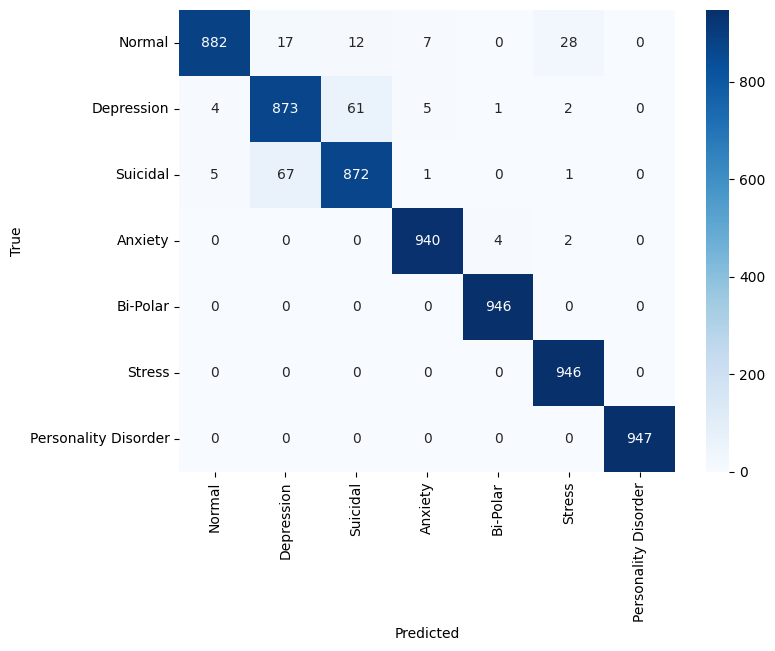

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def full_metrics():
    model.eval()
    preds_all, labels_all = [], []

    with torch.no_grad():
        for batch in valid_loader:
            inp = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            labels = batch["status"].to(device)

            logits = model(inp, attn)
            preds = logits.argmax(1)

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(labels_all, preds_all, target_names=list(label2id.keys())))

    cm = confusion_matrix(labels_all, preds_all)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(label2id.keys()),
                yticklabels=list(label2id.keys()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


full_metrics()


In [ ]:
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
train_losses


In [ ]:
plt.subplot(1,2,1)
plt.plot(train_acc, label='Train acc')
plt.plot(val_accuracies, label='Val acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('acc over Epochs')
plt.legend()